In [1]:
import tensorflow as tf
import pandas as pd
from keras_preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, CSVLogger
from keras.optimizers import Adam
from keras.models import Sequential, Model, load_model
from keras.layers import Conv2D, Flatten, MaxPooling2D, Input, BatchNormalization, Dropout, Dense

In [2]:
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
 tf.config.experimental.set_memory_growth(gpu, True)

In [3]:
gpus

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [4]:
train_path = 'train'
validation_path = 'val'
test_path = 'test'

train_datagen = ImageDataGenerator(
    rescale = 1 / 255.0,
    rotation_range = 10,
    zoom_range = 0.1,
    horizontal_flip = True
)

test_datagen = ImageDataGenerator(
    rescale = 1 / 255.0
)

train_gen = train_datagen.flow_from_directory(
    directory = train_path,
    target_size = (48,48),
    color_mode = 'grayscale',
    batch_size = 64,
    class_mode = 'categorical',
    shuffle = True,
    seed = 42
)

validation_gen = test_datagen.flow_from_directory(
    directory = validation_path,
    target_size = (48,48),
    color_mode = 'grayscale',
    batch_size = 64,
    class_mode = 'categorical',
    shuffle = True,
    seed = 42
)

test_gen = test_datagen.flow_from_directory(
    directory = test_path,
    target_size = (48,48),
    color_mode = 'grayscale',
    batch_size = 64,
    class_mode = 'categorical',
    shuffle = True,
    seed = 42
)

Found 28709 images belonging to 7 classes.
Found 3589 images belonging to 7 classes.
Found 3589 images belonging to 7 classes.


In [5]:
# model definition

model = Sequential()

model.add(Conv2D(filters=256, kernel_size=3, activation='relu', padding='same', input_shape=(48, 48, 1)))
model.add(Conv2D(filters=512, kernel_size=3, activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.4))

model.add(Conv2D(filters=256, kernel_size=3, activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.3))

model.add(Conv2D(filters=128, kernel_size=3, activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.3))

model.add(Conv2D(filters=256, kernel_size=3, activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.3))

model.add(Flatten())

model.add(Dense(256, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.3))
model.add(Dense(7, activation='softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 48, 48, 256)       2560      
                                                                 
 conv2d_1 (Conv2D)           (None, 48, 48, 512)       1180160   
                                                                 
 batch_normalization (BatchN  (None, 48, 48, 512)      2048      
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 24, 24, 512)      0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 24, 24, 512)       0         
                                                                 
 conv2d_2 (Conv2D)           (None, 24, 24, 256)       1

In [6]:
reduce_lr = ReduceLROnPlateau(monitor='val_loss',factor=0.5, patience = 4, verbose = 1)
early_stopping = EarlyStopping(monitor='val_loss', min_delta=0, patience = 20, verbose = 1)

optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001)
model_checkpoint = ModelCheckpoint('checkpoints/model_best.h5', save_best_only=True, monitor='val_acc', mode='max')
csv_logger = CSVLogger('history.log')

model.compile(loss = tf.keras.losses.categorical_crossentropy, metrics = 'acc', optimizer = optimizer)
history = model.fit(train_gen,validation_data = validation_gen, epochs = 150, callbacks = [model_checkpoint, csv_logger])

Epoch 1/150
449/449 [==============================] - 87s 171ms/step - loss: 1.9958 - acc: 0.2556 - val_loss: 1.7233 - val_acc: 0.3137
Epoch 2/150
449/449 [==============================] - 70s 156ms/step - loss: 1.6549 - acc: 0.3581 - val_loss: 1.6355 - val_acc: 0.3377
Epoch 3/150
449/449 [==============================] - 70s 155ms/step - loss: 1.4685 - acc: 0.4335 - val_loss: 1.3400 - val_acc: 0.4898
Epoch 4/150
449/449 [==============================] - 69s 155ms/step - loss: 1.3432 - acc: 0.4860 - val_loss: 1.3490 - val_acc: 0.4748
Epoch 5/150
449/449 [==============================] - 70s 155ms/step - loss: 1.2633 - acc: 0.5229 - val_loss: 1.2162 - val_acc: 0.5269
Epoch 6/150
449/449 [==============================] - 70s 155ms/step - loss: 1.2175 - acc: 0.5386 - val_loss: 1.2750 - val_acc: 0.5146
Epoch 7/150
449/449 [==============================] - 70s 155ms/step - loss: 1.1806 - acc: 0.5508 - val_loss: 1.1864 - val_acc: 0.5489
Epoch 8/150
449/449 [===========================

In [7]:
model.evaluate(test_gen, verbose=1)

57/57 [==============================] - 2s 36ms/step - loss: 0.9438 - acc: 0.7024


[0.9437918066978455, 0.7024240493774414]

In [8]:
import matplotlib.pyplot as plt

dict_keys(['loss', 'acc', 'val_loss', 'val_acc'])


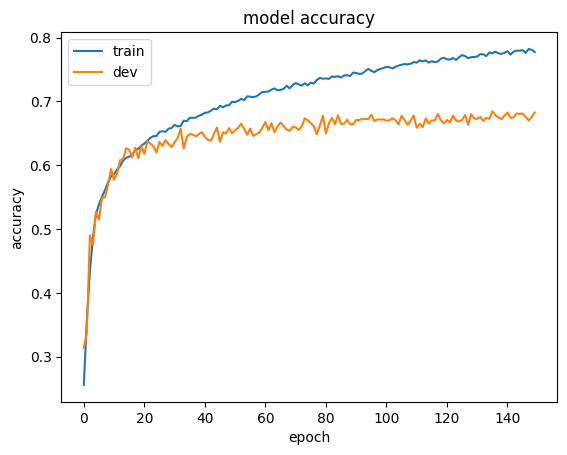

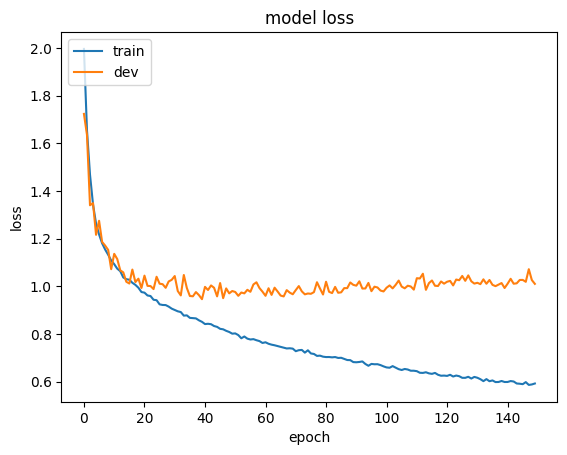

In [9]:
# list all data in history
print(history.history.keys())

plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'dev'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'dev'], loc='upper left')
plt.show()

In [12]:
best = load_model('CNN_69V-70T.h5')
best.evaluate(test_gen, verbose = 1)

57/57 [==============================] - 2s 35ms/step - loss: 0.9251 - acc: 0.7055


[0.9251172542572021, 0.7054889798164368]